## Applied Data Science Capstone - Final Project

### Introduction
In this project, we would like investigate which part of Hong Kong is the best place to open a gym & fitness club.

Starting a gym business not only could generate income through membership fees, but could also have a chance to transform the lives of numerious people.

### Data
A csv file contains all the areas located in 18 districts in Hong Kong, with the following columns:
- Area
- Districts
- Sub-Districts (neighborhood)
- Rental Value in HKD dollars

Using Open Street Map (OSM) - Nominatim to retrieve a specific location's latitude & longitude, with the following columns:
- Sub-Districts (neighborhood)
- latitude
- longitude

Using FourSquare to retrieve a specific location's nearby venues, with the following columns:
- Neighborhood
- Venue's latitude
- Venue's longitude
- Venue's category

### Methodology
1. Retrieve data from csv/OSM/FourSquare
2. Join different sources of data together, by using common joining key - Sub-Districts (neighborhood)
3. Handle with missing data
4. Count for each venue's frequency and sort for the top 10 most common venues in each neighborhood
5. Calculate the optimal k value for clustering
6. Examine each cluster, and come up with our analysis/conclusion

#### Import Libraries

In [1]:
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

from bs4 import BeautifulSoup

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


#### Load data

In [2]:
hk_district_df = pd.read_csv('hong_kong_district.csv')
hk_district_df.head()

,Area,District,Sub-districts,Rental Value (HKD)
0,Hong Kong,Central and Western,Kennedy Town,188000
1,Hong Kong,Central and Western,Shek Tong Tsui,188000
2,Hong Kong,Central and Western,Sai Ying Pun,188000
3,Hong Kong,Central and Western,Sheung Wan,188000
4,Hong Kong,Central and Western,Central,188000


In [3]:
table_contents=[]

for index, row in hk_district_df.iterrows():
    cell = {}
    
    address = row['Sub-districts']+', Hong Kong'
    
    geolocator = Nominatim(user_agent="hk_explorer")
    location = geolocator.geocode(address)
    if location == None:
        latitude = None
        longitude = None
    else:
        latitude = location.latitude
        longitude = location.longitude
    
    cell['Sub-districts']=row['Sub-districts']
    cell['latitude']=latitude
    cell['longitude']=longitude
    
    table_contents.append(cell)

In [4]:
table_contents

[{'Sub-districts': 'Kennedy Town',
  'latitude': 22.28131165,
  'longitude': 114.12916039816602},
 {'Sub-districts': 'Shek Tong Tsui',
  'latitude': 22.2858761,
  'longitude': 114.1357494},
 {'Sub-districts': 'Sai Ying Pun',
  'latitude': 22.286121,
  'longitude': 114.1420862},
 {'Sub-districts': 'Sheung Wan',
  'latitude': 22.2864829,
  'longitude': 114.1501973},
 {'Sub-districts': 'Central',
  'latitude': 22.2793278,
  'longitude': 114.1628131},
 {'Sub-districts': 'Admiralty',
  'latitude': 22.2850394,
  'longitude': 114.1583819},
 {'Sub-districts': 'Mid-levels',
  'latitude': 22.2769349,
  'longitude': 114.1559371},
 {'Sub-districts': 'Peak', 'latitude': 22.2819401, 'longitude': 114.15941335},
 {'Sub-districts': 'Wan Chai',
  'latitude': 22.2790146,
  'longitude': 114.1724833},
 {'Sub-districts': 'Causeway Bay',
  'latitude': 22.280208,
  'longitude': 114.1848407},
 {'Sub-districts': 'Happy Valley',
  'latitude': 22.2619181,
  'longitude': 114.1906285},
 {'Sub-districts': 'Tai Hang'

In [5]:
hk_lat_long_df=pd.DataFrame(table_contents)
hk_lat_long_df.head()

,Sub-districts,latitude,longitude
0,Kennedy Town,22.281312,114.129160
1,Shek Tong Tsui,22.285876,114.135749
2,Sai Ying Pun,22.286121,114.142086
3,Sheung Wan,22.286483,114.150197
4,Central,22.279328,114.162813


Join dataframes "hk_lat_long_df" and "hk_district_df" together. Drop sub-districts with null values in latitude and longitude. List first 5 sub-districts with their latitude and longitude.

In [6]:
hong_kong_df = pd.merge(hk_district_df, hk_lat_long_df, how='left', on = 'Sub-districts')
hong_kong_df.dropna(inplace=True)

In [7]:
hong_kong_df.head()

,Area,District,Sub-districts,Rental Value (HKD),latitude,longitude
0,Hong Kong,Central and Western,Kennedy Town,188000,22.281312,114.129160
1,Hong Kong,Central and Western,Shek Tong Tsui,188000,22.285876,114.135749
2,Hong Kong,Central and Western,Sai Ying Pun,188000,22.286121,114.142086
3,Hong Kong,Central and Western,Sheung Wan,188000,22.286483,114.150197
4,Hong Kong,Central and Western,Central,188000,22.279328,114.162813


List last 5 sub-districts with their latitude and longitude.

In [8]:
hong_kong_df.tail()

,Area,District,Sub-districts,Rental Value (HKD),latitude,longitude
121,New Territories,Sai Kung,Ma Yau Tong,148000,22.316965,114.244050
122,New Territories,Islands,Cheung Chau,105000,22.209614,114.029637
123,New Territories,Islands,Peng Chau,105000,22.286072,114.044371
124,New Territories,Islands,Lantau Island,105000,22.271469,113.944223
125,New Territories,Islands,Lamma island,105000,22.209441,114.149767


In [9]:
print('The dataframe has {} districts and {} sub-districts.'.format(
        len(hong_kong_df['District'].unique()),
        hong_kong_df.shape[0]
    )
)

The dataframe has 18 districts and 125 sub-districts.


#### Create a map of Hong Kong Area with neighborhoods 

In [10]:
address = 'Hong Kong'

geolocator = Nominatim(user_agent="hk_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of {} are {}, {}.'.format(address, latitude, longitude))

The geograpical coordinate of Hong Kong are 22.2793278, 114.1628131.


In [11]:
# create map of Toronto using latitude and longitude values
map_hk_area = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, neighborhood, district in zip(hong_kong_df['latitude']
                                           , hong_kong_df['longitude']
                                           , hong_kong_df['Sub-districts']
                                           , hong_kong_df['District']):
    label = '{}, {}'.format(neighborhood, district)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_hk_area)  
    
map_hk_area


#### Define Foursquare Credentials and Version

Explore all sub-districts (neighborhoods) in Hong Kong

In [138]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Loop through all sub-districts (neighborhoods) in Hong Kong and get all venues that could be found via FourSquare

In [14]:
hk_venues = getNearbyVenues(names=hong_kong_df['Sub-districts']
                            ,latitudes=hong_kong_df['latitude']
                            ,longitudes=hong_kong_df['longitude']
                                  )

Kennedy Town
Shek Tong Tsui
Sai Ying Pun
Sheung Wan
Central
Admiralty
Mid-levels
Peak
Wan Chai
Causeway Bay
Happy Valley
Tai Hang
So Kon Po
Jardine's Lookout
Tin Hau
Braemar Hill
North Point
Quarry Bay
Sai Wan Ho
Shau Kei Wan
Chai Wan
Siu Sai Wan
Pok Fu Lam
Aberdeen
Ap Lei Chau
Wong Chuk Hang
Shouson Hill
Repulse Bay
Chung Hom Kok
Stanley
Tai Tam
Shek O
Tsim Sha Tsui
Yau Ma Tei
West Kowloon Reclamation
King's Park
Mong Kok
Tai Kok Tsui
Mei Foo
Lai Chi Kok
Cheung Sha Wan
Sham Shui Po
Shek Kip Mei
Yau Yat Tsuen
Tai Wo Ping
Stonecutters Island
Hung Hom
Ma Tau Kok
Ma Tau Wai
Kai Tak
Kowloon City
Ho Man Tin
Kowloon Tong
Beacon Hill
San Po Kong
Wong Tai Sin
Tung Tau
Wang Tau Hom
Lok Fu
Diamond Hill
Tsz Wan Shan
Ngau Chi Wan
Ping Shek
Kowloon Bay
Ngau Tau Kok
Jordan Valley
Kwun Tong
Sau Mau Ping
Lam Tin
Yau Tong
Lei Yue Mun
Kwai Chung
Tsing Yi
Tsuen Wan
Lei Muk Shue
Ting Kau
Sham Tseng
Tsing Lung Tau
Ma Wan
Sunny Bay
Tai Lam Chung
So Kwun Wat
Tuen Mun
Lam Tei
Hung Shui Kiu
Ha Tsuen
Lau Fau Sh

In [15]:
print(hk_venues.shape)
hk_venues.head()

(2826, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Kennedy Town,22.281312,114.12916,Winstons Coffee,22.281374,114.127172,Coffee Shop
1,Kennedy Town,22.281312,114.12916,Aziza,22.282753,114.127365,Egyptian Restaurant
2,Kennedy Town,22.281312,114.12916,Comptoir,22.281209,114.126975,French Restaurant
3,Kennedy Town,22.281312,114.12916,Bresola,22.283166,114.126902,Italian Restaurant
4,Kennedy Town,22.281312,114.12916,Thai Relax Massage,22.283217,114.127326,Spa


In [16]:
hk_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Aberdeen,30,30,30,30,30,30
Admiralty,60,60,60,60,60,60
Ap Lei Chau,19,19,19,19,19,19
Beacon Hill,2,2,2,2,2,2
Braemar Hill,8,8,8,8,8,8
Causeway Bay,44,44,44,44,44,44
Central,46,46,46,46,46,46
Chai Wan,85,85,85,85,85,85
Cheung Chau,22,22,22,22,22,22


In [17]:
print('There are {} uniques categories.'.format(len(hk_venues['Venue Category'].unique())))

There are 253 uniques categories.


#### Analyze each neighborhood in Hong Kong

In [18]:
# one hot encoding
hk_onehot = pd.get_dummies(hk_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
hk_onehot['Neighborhood'] = hk_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [hk_onehot.columns[-1]] + list(hk_onehot.columns[:-1])
hk_onehot = hk_onehot[fixed_columns]

hk_onehot = hk_onehot.set_index('Neighborhood')
hk_onehot.shape
hk_onehot.head()

,Zoo Exhibit,African Restaurant,American Restaurant,Aquarium,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Australian Restaurant,BBQ Joint,Badminton Court,Bakery,Balinese Restaurant,Bank,Bar,Beach,Beer Bar,Beer Store,Beijing Restaurant,Belgian Restaurant,Betting Shop,Bistro,Boat or Ferry,Bookstore,Border Crossing,Botanical Garden,Boutique,Breakfast Spot,Brewery,Bubble Tea Shop,Buffet,Building,Burger Joint,Bus Station,Bus Stop,Butcher,Cable Car,Café,Camera Store,Campground,Cantonese Restaurant,Cha Chaan Teng,Chinese Breakfast Place,Chinese Restaurant,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,College Cafeteria,Comfort Food Restaurant,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Cricket Ground,Cupcake Shop,Cycle Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Donburi Restaurant,Dongbei Restaurant,Dumpling Restaurant,Egyptian Restaurant,Electronics Store,English Restaurant,Exhibit,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Gas Station,Gastropub,General Entertainment,German Restaurant,Gift Shop,Go Kart Track,Golf Course,Gourmet Shop,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hainan Restaurant,Hakka Restaurant,Halal Restaurant,Harbor / Marina,Health Food Store,History Museum,Hong Kong Restaurant,Hookah Bar,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,Housing Development,Hunan Restaurant,Ice Cream Shop,Imported Food Shop,Indian Restaurant,Indie Theater,Indonesian Restaurant,Indoor Play Area,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jewelry Store,Jiangsu Restaurant,Juice Bar,Karaoke Bar,Kids Store,Korean BBQ Restaurant,Korean Restaurant,Lake,Lebanese Restaurant,Light Rail Station,Lighthouse,Liquor Store,Lounge,Macanese Restaurant,Malay Restaurant,Market,Massage Studio,Mediterranean Restaurant,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Mountain,Movie Theater,Multiplex,Museum,Music Venue,New American Restaurant,Non-Profit,Noodle House,Office,Optical Shop,Other Great Outdoors,Outdoor Sculpture,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Perfume Shop,Pet Store,Pharmacy,Photography Studio,Pie Shop,Pier,Pizza Place,Platform,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Pub,Public Art,Public Bathroom,Ramen Restaurant,Record Shop,Reservoir,Residential Building (Apartment / Condo),Rest Area,Restaurant,River,Sake Bar,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,Shoe Store,Shopping Mall,Singaporean Restaurant,Snack Place,Social Club,Soup Place,South Indian Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sri Lankan Restaurant,Stables,Stadium,Stationery Store,Steakhouse,Supermarket,Surf Spot,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tapas Restaurant,Tea Room,Temple,Tennis Court,Thai Restaurant,Theater,Theme Park,Theme Park Ride / Attraction,Tibetan Restaurant,Toy / Game Store,Track Stadium,Trail,Train Station,Tram Station,Tunnel,Turkish Restaurant,Udon Restaurant,Used Bookstore,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Water Park,Waterfall,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Yoga Studio,Yunnan Restaurant,Zhejiang Restaurant,Zoo
Neighborhood,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Kennedy Town,0,0,0,0,0,0,0,0,0,0,0,

Let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [19]:
hk_grouped = hk_onehot.groupby('Neighborhood').mean().reset_index()
hk_grouped.shape
hk_grouped.head()

,Neighborhood,Zoo Exhibit,African Restaurant,American Restaurant,Aquarium,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Australian Restaurant,BBQ Joint,Badminton Court,Bakery,Balinese Restaurant,Bank,Bar,Beach,Beer Bar,Beer Store,Beijing Restaurant,Belgian Restaurant,Betting Shop,Bistro,Boat or Ferry,Bookstore,Border Crossing,Botanical Garden,Boutique,Breakfast Spot,Brewery,Bubble Tea Shop,Buffet,Building,Burger Joint,Bus Station,Bus Stop,Butcher,Cable Car,Café,Camera Store,Campground,Cantonese Restaurant,Cha Chaan Teng,Chinese Breakfast Place,Chinese Restaurant,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,College Cafeteria,Comfort Food Restaurant,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Cricket Ground,Cupcake Shop,Cycle Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Donburi Restaurant,Dongbei Restaurant,Dumpling Restaurant,Egyptian Restaurant,Electronics Store,English Restaurant,Exhibit,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Gas Station,Gastropub,General Entertainment,German Restaurant,Gift Shop,Go Kart Track,Golf Course,Gourmet Shop,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hainan Restaurant,Hakka Restaurant,Halal Restaurant,Harbor / Marina,Health Food Store,History Museum,Hong Kong Restaurant,Hookah Bar,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,Housing Development,Hunan Restaurant,Ice Cream Shop,Imported Food Shop,Indian Restaurant,Indie Theater,Indonesian Restaurant,Indoor Play Area,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jewelry Store,Jiangsu Restaurant,Juice Bar,Karaoke Bar,Kids Store,Korean BBQ Restaurant,Korean Restaurant,Lake,Lebanese Restaurant,Light Rail Station,Lighthouse,Liquor Store,Lounge,Macanese Restaurant,Malay Restaurant,Market,Massage Studio,Mediterranean Restaurant,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Mountain,Movie Theater,Multiplex,Museum,Music Venue,New American Restaurant,Non-Profit,Noodle House,Office,Optical Shop,Other Great Outdoors,Outdoor Sculpture,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Perfume Shop,Pet Store,Pharmacy,Photography Studio,Pie Shop,Pier,Pizza Place,Platform,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Pub,Public Art,Public Bathroom,Ramen Restaurant,Record Shop,Reservoir,Residential Building (Apartment / Condo),Rest Area,Restaurant,River,Sake Bar,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,Shoe Store,Shopping Mall,Singaporean Restaurant,Snack Place,Social Club,Soup Place,South Indian Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sri Lankan Restaurant,Stables,Stadium,Stationery Store,Steakhouse,Supermarket,Surf Spot,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tapas Restaurant,Tea Room,Temple,Tennis Court,Thai Restaurant,Theater,Theme Park,Theme Park Ride / Attraction,Tibetan Restaurant,Toy / Game Store,Track Stadium,Trail,Train Station,Tram Station,Tunnel,Turkish Restaurant,Udon Restaurant,Used Bookstore,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Water Park,Waterfall,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Yoga Studio,Yunnan Restaurant,Zhejiang Restaurant,Zoo
0,Aberdeen,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.033333,0.066667,0.0,0.0,0.0,0.000000,0.0,0.0,0.00,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.033333,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.033333,0.033333,0.0,0.0,0.000000,0.0,0.0,0.000000,0.066667,0.0,0.066667,0.0,0.000000,

Let's print each neighborhood along with the top 5 most common venues

In [20]:
num_top_venues = 5

for hood in hk_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = hk_grouped[hk_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Aberdeen----
                  venue  freq
0           Supermarket  0.07
1        Cha Chaan Teng  0.07
2  Taiwanese Restaurant  0.07
3    Chinese Restaurant  0.07
4    Athletics & Sports  0.07


----Admiralty----
                  venue  freq
0  Cantonese Restaurant  0.07
1   Japanese Restaurant  0.07
2                 Hotel  0.05
3                   Bar  0.05
4                Lounge  0.05


----Ap Lei Chau----
                  venue  freq
0  Fast Food Restaurant  0.16
1    Chinese Restaurant  0.11
2         Shopping Mall  0.11
3          Burger Joint  0.05
4          Cupcake Shop  0.05


----Beacon Hill----
                  venue  freq
0        Scenic Lookout   0.5
1              Mountain   0.5
2           Zoo Exhibit   0.0
3              Platform   0.0
4  Pakistani Restaurant   0.0


----Braemar Hill----
                  venue  freq
0   Japanese Restaurant  0.25
1  Taiwanese Restaurant  0.12
2      Malay Restaurant  0.12
3  Fast Food Restaurant  0.12
4           Art Gallery  0

                venue  freq
0  Chinese Restaurant  0.31
1  Athletics & Sports  0.15
2          Restaurant  0.08
3                 Gym  0.08
4   Electronics Store  0.08


----Sheung Shui----
                  venue  freq
0  Fast Food Restaurant  0.22
1           Coffee Shop  0.11
2    Athletics & Sports  0.11
3           Bus Station  0.11
4  Gym / Fitness Center  0.11


----Sheung Wan----
                 venue  freq
0  Japanese Restaurant  0.15
1          Coffee Shop  0.06
2    French Restaurant  0.06
3         Cocktail Bar  0.06
4   Chinese Restaurant  0.06


----Shouson Hill----
                          venue  freq
0  Theme Park Ride / Attraction  0.14
1                   Zoo Exhibit  0.09
2                    Theme Park  0.09
3                 Metro Station  0.05
4                     Cable Car  0.05


----Shuen Wan----
          venue  freq
0    Restaurant   0.5
1    Water Park   0.5
2   Zoo Exhibit   0.0
3  Perfume Shop   0.0
4          Pier   0.0


----Siu Sai Wan----
          

In [21]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Display the top 10 venues for each neighborhood, and loaded into dataframe

In [72]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = hk_grouped['Neighborhood']

for ind in np.arange(hk_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(hk_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Aberdeen,Cha Chaan Teng,Chinese Restaurant,Supermarket,Taiwanese Restaurant,Coffee Shop,Hong Kong Restaurant,Athletics & Sports,Boat or Ferry,Shopping Mall,Thai Restaurant
1,Admiralty,Japanese Restaurant,Cantonese Restaurant,Lounge,Bar,Hotel,Hotel Bar,French Restaurant,Cocktail Bar,Spa,Fried Chicken Joint
2,Ap Lei Chau,Fast Food Restaurant,Chinese Restaurant,Shopping Mall,Clothing Store,Hotel,Furniture / Home Store,Burger Joint,Paper / Office Supplies Store,Café,Mountain
3,Beacon Hill,Scenic Lookout,Mountain,Zoo,Fish & Chips Shop,Gastropub,Gas Station,Garden,Furniture / Home Store,Frozen Yogurt Shop,Fried Chicken Joint
4,Braemar Hill,Japanese Restaurant,Chinese Restaurant,Taiwanese Restaurant,Ramen Restaurant,Art Gallery,Malay Restaurant,Fast Food Restaurant,Zoo,French Restaurant,Food & Drink Shop


#### Cluster Neighborhoods in Hong Kong
Determine the optimal k-mean value using silhouette score method. A high value is desirable and indicates that the point is placed in the correct cluster.

In [81]:
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

sil = []
kmax = 10

hk_clustering = hk_grouped.drop('Neighborhood', 1)

#dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in range(2, kmax+1):
    kmeans = KMeans(n_clusters = k).fit(hk_clustering)
    labels = kmeans.labels_
    sil.append(silhouette_score(hk_clustering, labels, metric = 'euclidean'))

Text(0, 0.5, 'silhouette score')

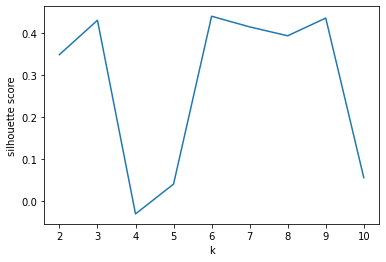

In [82]:
plt.plot(range(2,11), sil)
plt.xlabel("k")
plt.ylabel("silhouette score")

The k value is optimal at k=9, so will choose k=9 for the clustering

In [83]:
# set number of clusters
kclusters = 9

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(hk_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([5, 0, 5, 3, 5, 0, 0, 0, 0, 5], dtype=int32)

Add clustering labels into the dataframe, and merge the grouped dataframe into the original one. Print the first 5 rows in the merged daataframe

In [84]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [85]:
# rename column in dataframe "hong_kong_df"
hk_merged = hong_kong_df
hk_merged = hk_merged.rename(columns={"Sub-districts": "Neighborhood"})
hk_merged

# merge hk_merged with manhattan_data to add latitude/longitude for each neighborhood
hk_merged = hk_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

hk_merged.head()

,Area,District,Neighborhood,Rental Value (HKD),latitude,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Hong Kong,Central and Western,Kennedy Town,188000,22.281312,114.129160,0.0,Japanese Restaurant,Cha Chaan Teng,Coffee Shop,French Restaurant,Vietnamese Restaurant,Mexican Restaurant,Sushi Restaurant,Dim Sum Restaurant,Indian Restaurant,Park
1,Hong Kong,Central and Western,Shek Tong Tsui,188000,22.285876,114.135749,0.0,Noodle House,Indonesian Restaurant,Coffee Shop,BBQ Joint,Burger Joint,Café,Supermarket,Furniture / Home Store,Cantonese Restaurant,French Restaurant
2,Hong Kong,Central and Western,Sai Ying Pun,188000,22.286121,114.142086,0.0,Coffee Shop,French Restaurant,Thai Restaurant,Tapas Restaurant,Steakhouse,Hong Kong Restaurant,Noodle House,Hotel,Indonesian Restaurant,Park
3,Hong Kong,Central and Western,Sheung Wan,188000,22.286483,114.150197,0.0,Japanese Restaurant,Chinese Restaurant,Cocktail Bar,Coffee Shop,French Restaurant,Bar,Café,Wine Bar,Italian Restaurant,Snack Place
4,Hong Kong,Central and Western,Central,188000,22.279328,114.162813,0.0,Café,Hotel,Lounge,Steakhouse,Art Gallery,Park,Bookstore,Italian Restaurant,Seafood Restaurant,Zoo


Print the last 5 rows in the dataframe

In [86]:
hk_merged.tail()

,Area,District,Neighborhood,Rental Value (HKD),latitude,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
121,New Territories,Sai Kung,Ma Yau Tong,148000,22.316965,114.244050,8.0,Tunnel,Bus Stop,German Restaurant,Gastropub,Gas Station,Garden,Furniture / Home Store,Frozen Yogurt Shop,Fried Chicken Joint,French Restaurant
122,New Territories,Islands,Cheung Chau,105000,22.209614,114.029637,0.0,Seafood Restaurant,Snack Place,Dessert Shop,Chinese Restaurant,Café,Fast Food Restaurant,Beach,Coffee Shop,Bakery,Pier
123,New Territories,Islands,Peng Chau,105000,22.286072,114.044371,0.0,Scenic Lookout,Trail,Harbor / Marina,Zoo,French Restaurant,Flea Market,Food & Drink Shop,Food Court,Food Truck,Fried Chicken Joint
124,New Territories,Islands,Lantau Island,105000,22.271469,113.944223,0.0,Trail,Zoo,Gift Shop,General Entertainment,Gastropub,Gas Station,Garden,Furniture / Home Store,Frozen Yogurt Shop,Fried Chicken Joint
125,New Territories,Islands,Lamma island,105000,22.209441,114.149767,0.0,Pier,Mediterranean Restaurant,Zoo,Gift Shop,General Entertainment,Gastropub,Gas Station,Garden,Furniture / Home Store,Frozen Yogurt Shop


In [87]:
hk_merged.dropna(inplace=True)
hk_merged.shape

(122, 17)

In [88]:
# brief summary of dataframe
pd.Series({c: hk_merged[c].unique() for c in hk_merged})

Area                                  [Hong Kong, Kowloon, New Territories]
District                  [Central and Western, Wan Chai, Eastern, South...
Neighborhood              [Kennedy Town, Shek Tong Tsui, Sai Ying Pun, S...
Rental Value (HKD)        [188000, 194000, 175000, 157000, 144000, 13700...
latitude                  [22.28131165, 22.2858761, 22.286121, 22.286482...
longitude                 [114.12916039816602, 114.1357494, 114.1420862,...
Cluster Labels                [0.0, 5.0, 3.0, 2.0, 1.0, 4.0, 8.0, 6.0, 7.0]
1st Most Common Venue     [Japanese Restaurant, Noodle House, Coffee Sho...
2nd Most Common Venue     [Cha Chaan Teng, Indonesian Restaurant, French...
3rd Most Common Venue     [Coffee Shop, Thai Restaurant, Cocktail Bar, L...
4th Most Common Venue     [French Restaurant, BBQ Joint, Tapas Restauran...
5th Most Common Venue     [Vietnamese Restaurant, Burger Joint, Steakhou...
6th Most Common Venue     [Mexican Restaurant, Café, Hong Kong Restauran...
7th Most Com

In [89]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(hk_merged['latitude']
                                , hk_merged['longitude']
                                , hk_merged['Neighborhood']
                                , hk_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

#### Examine Clusters

In [90]:
##Cluster 1
hk_merged.loc[hk_merged['Cluster Labels'] == 0, hk_merged.columns[[1]+[2]+[3]+list(range(6, hk_merged.shape[1]))]]


,District,Neighborhood,Rental Value (HKD),Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Central and Western,Kennedy Town,188000,0.0,Japanese Restaurant,Cha Chaan Teng,Coffee Shop,French Restaurant,Vietnamese Restaurant,Mexican Restaurant,Sushi Restaurant,Dim Sum Restaurant,Indian Restaurant,Park
1,Central and Western,Shek Tong Tsui,188000,0.0,Noodle House,Indonesian Restaurant,Coffee Shop,BBQ Joint,Burger Joint,Café,Supermarket,Furniture / Home Store,Cantonese Restaurant,French Restaurant
2,Central and Western,Sai Ying Pun,188000,0.0,Coffee Shop,French Restaurant,Thai Restaurant,Tapas Restaurant,Steakhouse,Hong Kong Restaurant,Noodle House,Hotel,Indonesian Restaurant,Park
3,Central and Western,Sheung Wan,188000,0.0,Japanese Restaurant,Chinese Restaurant,Cocktail Bar,Coffee Shop,French Restaurant,Bar,Café,Wine Bar,Italian Restaurant,Snack Place
4,Central and Western,Central,188000,0.0,Café,Hotel,Lounge,Steakhouse,Art Gallery,Park,Bookstore,Italian Restaurant,Seafood Restaurant,Zoo
5,Central and Western,Admiralty,188000,0.0,Japanese Restaurant,Cantonese Restaurant,Lounge,Bar,Hotel,Hotel Bar,French Restaurant,Cocktail Bar,Spa,Fried Chicken Joint
6,Central and Western,Mid-levels,188000,0.0,Japanese Restaurant,Café,Bar,Hotel,Playground,Cocktail Bar,Gym,French Restaurant,Sushi Restaurant,Spa
7,Central and Western,Peak,188000,0.0,Japanese Restaurant,Bar,Lounge,Gym / Fitness Center,Gym,Cantonese Restaurant,Cocktail Bar,Hotel,Art Gallery,Hotel Bar
8,Wan Chai,Wan Chai,194000,0.0,Café,Japanese Restaurant,Italian Restaurant,Hotel,Coffee Shop,Bakery,Chinese Restaurant,Massage Studio,Spanish Restaurant,Middle Eastern Restaurant
9,Wan Chai,Causeway Bay,194000,0.0,Japanese Restaurant,Bakery,Dessert Shop,Chinese Restaurant,Coffee Shop,Seafood Restaurant,Clothing Store,Bookstore,Supermarket,Gift Shop


In [95]:
##Cluster 6
hk_merged.loc[hk_merged['Cluster Labels'] == 5, hk_merged.columns[[1]+[2]+[3]+list(range(6, hk_merged.shape[1]))]]




,District,Neighborhood,Rental Value (HKD),Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
10,Wan Chai,Happy Valley,194000,5.0,Chinese Restaurant,Bus Station,Cricket Ground,Tennis Court,Bus Stop,Coffee Shop,French Restaurant,Flea Market,Food & Drink Shop,Food Court
12,Wan Chai,So Kon Po,194000,5.0,Chinese Restaurant,Japanese Restaurant,Coffee Shop,Italian Restaurant,Sushi Restaurant,Café,Thai Restaurant,Hong Kong Restaurant,Bakery,Shanghai Restaurant
15,Eastern,Braemar Hill,175000,5.0,Japanese Restaurant,Chinese Restaurant,Taiwanese Restaurant,Ramen Restaurant,Art Gallery,Malay Restaurant,Fast Food Restaurant,Zoo,French Restaurant,Food & Drink Shop
18,Eastern,Sai Wan Ho,175000,5.0,Chinese Restaurant,Restaurant,Shopping Mall,Museum,Cantonese Restaurant,Coffee Shop,Dessert Shop,Indian Restaurant,Dongbei Restaurant,Fish Market
19,Eastern,Shau Kei Wan,175000,5.0,Fast Food Restaurant,Noodle House,Cha Chaan Teng,Dim Sum Restaurant,Snack Place,Shopping Mall,Convenience Store,BBQ Joint,Tram Station,Hong Kong Restaurant
21,Eastern,Siu Sai Wan,175000,5.0,Fast Food Restaurant,Supermarket,Convenience Store,Dim Sum Restaurant,Udon Restaurant,Café,Park,Cha Chaan Teng,Chinese Restaurant,Market
22,Southern,Pok Fu Lam,157000,5.0,Bus Stop,Fast Food Restaurant,Supermarket,Convenience Store,Hotel,Stables,Bus Station,Reservoir,Donburi Restaurant,Diner
23,Southern,Aberdeen,157000,5.0,Cha Chaan Teng,Chinese Restaurant,Supermarket,Taiwanese Restaurant,Coffee Shop,Hong Kong Restaurant,Athletics & Sports,Boat or Ferry,Shopping Mall,Thai Restaurant
24,Southern,Ap Lei Chau,157000,5.0,Fast Food Restaurant,Chinese Restaurant,Shopping Mall,Clothing Store,Hotel,Furniture / Home Store,Burger Joint,Paper / Office Supplies Store,Café,Mountain
36,Yau Tsim Mong,Mong Kok,144000,5.0,Cha Chaan Teng,Noodle House,Coffee Shop,Dessert Shop,Beer Bar,Vegetarian / Vegan Restaurant,Chinese Restaurant,Market,Fast Food Restaurant,Cantonese Restaurant


#### Analysis
Based on the result of K-means clustering, most of the venues are clustered into "Cluster 1", so we would focus on analysing this specific cluster. Convert all values in dataframe into uppercase, and then filter out those neighborhoods that already contain gym/fitness centers as their top 10 most common venue list.


In [96]:
hk_cluster_1 = hk_merged.loc[hk_merged['Cluster Labels'] == 5, hk_merged.columns[[1]+[2]+[3]+list(range(6, hk_merged.shape[1]))]]
hk_cluster_1 = hk_cluster_1.apply(lambda x: x.astype(str).str.upper())
hk_cluster_1


,District,Neighborhood,Rental Value (HKD),Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
10,WAN CHAI,HAPPY VALLEY,194000,5.0,CHINESE RESTAURANT,BUS STATION,CRICKET GROUND,TENNIS COURT,BUS STOP,COFFEE SHOP,FRENCH RESTAURANT,FLEA MARKET,FOOD & DRINK SHOP,FOOD COURT
12,WAN CHAI,SO KON PO,194000,5.0,CHINESE RESTAURANT,JAPANESE RESTAURANT,COFFEE SHOP,ITALIAN RESTAURANT,SUSHI RESTAURANT,CAFÉ,THAI RESTAURANT,HONG KONG RESTAURANT,BAKERY,SHANGHAI RESTAURANT
15,EASTERN,BRAEMAR HILL,175000,5.0,JAPANESE RESTAURANT,CHINESE RESTAURANT,TAIWANESE RESTAURANT,RAMEN RESTAURANT,ART GALLERY,MALAY RESTAURANT,FAST FOOD RESTAURANT,ZOO,FRENCH RESTAURANT,FOOD & DRINK SHOP
18,EASTERN,SAI WAN HO,175000,5.0,CHINESE RESTAURANT,RESTAURANT,SHOPPING MALL,MUSEUM,CANTONESE RESTAURANT,COFFEE SHOP,DESSERT SHOP,INDIAN RESTAURANT,DONGBEI RESTAURANT,FISH MARKET
19,EASTERN,SHAU KEI WAN,175000,5.0,FAST FOOD RESTAURANT,NOODLE HOUSE,CHA CHAAN TENG,DIM SUM RESTAURANT,SNACK PLACE,SHOPPING MALL,CONVENIENCE STORE,BBQ JOINT,TRAM STATION,HONG KONG RESTAURANT
21,EASTERN,SIU SAI WAN,175000,5.0,FAST FOOD RESTAURANT,SUPERMARKET,CONVENIENCE STORE,DIM SUM RESTAURANT,UDON RESTAURANT,CAFÉ,PARK,CHA CHAAN TENG,CHINESE RESTAURANT,MARKET
22,SOUTHERN,POK FU LAM,157000,5.0,BUS STOP,FAST FOOD RESTAURANT,SUPERMARKET,CONVENIENCE STORE,HOTEL,STABLES,BUS STATION,RESERVOIR,DONBURI RESTAURANT,DINER
23,SOUTHERN,ABERDEEN,157000,5.0,CHA CHAAN TENG,CHINESE RESTAURANT,SUPERMARKET,TAIWANESE RESTAURANT,COFFEE SHOP,HONG KONG RESTAURANT,ATHLETICS & SPORTS,BOAT OR FERRY,SHOPPING MALL,THAI RESTAURANT
24,SOUTHERN,AP LEI CHAU,157000,5.0,FAST FOOD RESTAURANT,CHINESE RESTAURANT,SHOPPING MALL,CLOTHING STORE,HOTEL,FURNITURE / HOME STORE,BURGER JOINT,PAPER / OFFICE SUPPLIES STORE,CAFÉ,MOUNTAIN
36,YAU TSIM MONG,MONG KOK,144000,5.0,CHA CHAAN TENG,NOODLE HOUSE,COFFEE SHOP,DESSERT SHOP,BEER BAR,VEGETARIAN / VEGAN RESTAURANT,CHINESE RESTAURANT,MARKET,FAST FOOD RESTAURANT,CANTONESE RESTAURANT


In [97]:
hk_cluster_1[hk_cluster_1.isin(['GYM']).any(axis=1)]


,District,Neighborhood,Rental Value (HKD),Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
98,NORTH,SHEK WU HUI,92000,5.0,CHINESE RESTAURANT,ATHLETICS & SPORTS,ELECTRONICS STORE,HONG KONG RESTAURANT,COFFEE SHOP,GYM,NOODLE HOUSE,RESTAURANT,GYM / FITNESS CENTER,FRIED CHICKEN JOINT


In [98]:
hk_cluster_1[hk_cluster_1.isin(['ATHLETICS & SPORTS']).any(axis=1)]

,District,Neighborhood,Rental Value (HKD),Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
23,SOUTHERN,ABERDEEN,157000,5.0,CHA CHAAN TENG,CHINESE RESTAURANT,SUPERMARKET,TAIWANESE RESTAURANT,COFFEE SHOP,HONG KONG RESTAURANT,ATHLETICS & SPORTS,BOAT OR FERRY,SHOPPING MALL,THAI RESTAURANT
61,WONG TAI SIN,TSZ WAN SHAN,121000,5.0,CHINESE RESTAURANT,FAST FOOD RESTAURANT,ASIAN RESTAURANT,SHOPPING MALL,CHA CHAAN TENG,BBQ JOINT,FRIED CHICKEN JOINT,ATHLETICS & SPORTS,DONBURI RESTAURANT,PARK
62,WONG TAI SIN,NGAU CHI WAN,121000,5.0,CHA CHAAN TENG,BUS STATION,BUS STOP,FAST FOOD RESTAURANT,CONCERT HALL,SNACK PLACE,CANTONESE RESTAURANT,FARMERS MARKET,ATHLETICS & SPORTS,PLAYGROUND
97,NORTH,SHEUNG SHUI,92000,5.0,FAST FOOD RESTAURANT,CANTONESE RESTAURANT,BUS STATION,COFFEE SHOP,SHOPPING MALL,GYM / FITNESS CENTER,CHINESE RESTAURANT,ATHLETICS & SPORTS,ZOO,FOOD & DRINK SHOP
98,NORTH,SHEK WU HUI,92000,5.0,CHINESE RESTAURANT,ATHLETICS & SPORTS,ELECTRONICS STORE,HONG KONG RESTAURANT,COFFEE SHOP,GYM,NOODLE HOUSE,RESTAURANT,GYM / FITNESS CENTER,FRIED CHICKEN JOINT
119,SAI KUNG,HANG HAU,148000,5.0,FAST FOOD RESTAURANT,CAFÉ,CANTONESE RESTAURANT,PHARMACY,CHA CHAAN TENG,SHOPPING MALL,COFFEE SHOP,ATHLETICS & SPORTS,SUPERMARKET,SHABU-SHABU RESTAURANT
120,SAI KUNG,TIU KENG LENG,148000,5.0,FAST FOOD RESTAURANT,COFFEE SHOP,FARMERS MARKET,DIM SUM RESTAURANT,HOUSING DEVELOPMENT,THAI RESTAURANT,CANTONESE RESTAURANT,CHINESE RESTAURANT,UDON RESTAURANT,ATHLETICS & SPORTS


In [99]:
hk_cluster_1=hk_cluster_1[~hk_cluster_1.isin(['GYM']).any(axis=1)]
hk_cluster_1=hk_cluster_1[~hk_cluster_1.isin(['ATHLETICS & SPORTS']).any(axis=1)]

Most of the Hotels in Hong Kong contain fitness centers, so we would like to filter our neighborhoods that have hotels as their common venues, so as to enhance our business competitiveness 

In [100]:
hk_cluster_1[hk_cluster_1.isin(['HOTEL']).any(axis=1)]

,District,Neighborhood,Rental Value (HKD),Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
22,SOUTHERN,POK FU LAM,157000,5.0,BUS STOP,FAST FOOD RESTAURANT,SUPERMARKET,CONVENIENCE STORE,HOTEL,STABLES,BUS STATION,RESERVOIR,DONBURI RESTAURANT,DINER
24,SOUTHERN,AP LEI CHAU,157000,5.0,FAST FOOD RESTAURANT,CHINESE RESTAURANT,SHOPPING MALL,CLOTHING STORE,HOTEL,FURNITURE / HOME STORE,BURGER JOINT,PAPER / OFFICE SUPPLIES STORE,CAFÉ,MOUNTAIN
46,KOWLOON CITY,HUNG HOM,146000,5.0,COFFEE SHOP,HOTEL,CANTONESE RESTAURANT,CHINESE RESTAURANT,FAST FOOD RESTAURANT,OPTICAL SHOP,NOODLE HOUSE,STADIUM,CAFÉ,FOOD COURT
49,KOWLOON CITY,MA TAU WAI,146000,5.0,CAFÉ,FAST FOOD RESTAURANT,COFFEE SHOP,HONG KONG RESTAURANT,BAKERY,HOSTEL,HOTEL,SHOPPING MALL,THAI RESTAURANT,FOOD & DRINK SHOP
55,WONG TAI SIN,SAN PO KONG,121000,5.0,FAST FOOD RESTAURANT,NOODLE HOUSE,ARTS & ENTERTAINMENT,CHA CHAAN TENG,SHOPPING MALL,SUPERMARKET,MARKET,COFFEE SHOP,THAI RESTAURANT,HOTEL
65,KWUN TONG,NGAU TAU KOK,124000,5.0,COFFEE SHOP,CHA CHAAN TENG,HOTEL,FAST FOOD RESTAURANT,CAFÉ,HONG KONG RESTAURANT,CHINESE RESTAURANT,CANTONESE RESTAURANT,HAINAN RESTAURANT,THAI RESTAURANT


In [101]:
hk_cluster_1=hk_cluster_1[~hk_cluster_1.isin(['HOTEL']).any(axis=1)]

We would like to filter out neighborhoods that presumably would have low demand for gym/fitness equipments/services, such as pier/river, zoo, beach, campground


In [102]:
hk_cluster_1[hk_cluster_1.isin(['PIER']).any(axis=1)]

,District,Neighborhood,Rental Value (HKD),Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
77,TSUEN WAN,SHAM TSENG,149000,5.0,BUS STOP,CHINESE RESTAURANT,COFFEE SHOP,HONG KONG RESTAURANT,SUPERMARKET,CAFÉ,PIER,SHOPPING MALL,GROCERY STORE,FAST FOOD RESTAURANT
78,TSUEN WAN,TSING LUNG TAU,149000,5.0,CHINESE RESTAURANT,DINER,BUS STOP,PIER,FISH MARKET,GASTROPUB,GAS STATION,GARDEN,FURNITURE / HOME STORE,FROZEN YOGURT SHOP


In [103]:
hk_cluster_1 = hk_cluster_1[~hk_cluster_1.isin(['PIER']).any(axis=1)]

In [105]:
hk_cluster_1[hk_cluster_1.isin(['ZOO']).any(axis=1)]

,District,Neighborhood,Rental Value (HKD),Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
15,EASTERN,BRAEMAR HILL,175000,5.0,JAPANESE RESTAURANT,CHINESE RESTAURANT,TAIWANESE RESTAURANT,RAMEN RESTAURANT,ART GALLERY,MALAY RESTAURANT,FAST FOOD RESTAURANT,ZOO,FRENCH RESTAURANT,FOOD & DRINK SHOP
63,KWUN TONG,PING SHEK,124000,5.0,CHA CHAAN TENG,BUS STOP,FAST FOOD RESTAURANT,BURGER JOINT,BUS STATION,PARK,CONCERT HALL,ZOO,FOOD TRUCK,FRENCH RESTAURANT
68,KWUN TONG,SAU MAU PING,124000,5.0,FAST FOOD RESTAURANT,ZOO,FISH & CHIPS SHOP,GENERAL ENTERTAINMENT,GASTROPUB,GAS STATION,GARDEN,FURNITURE / HOME STORE,FROZEN YOGURT SHOP,FRIED CHICKEN JOINT
82,TUEN MUN,SO KWUN WAT,96000,5.0,CHA CHAAN TENG,ZOO,FISH MARKET,GENERAL ENTERTAINMENT,GASTROPUB,GAS STATION,GARDEN,FURNITURE / HOME STORE,FROZEN YOGURT SHOP,FRIED CHICKEN JOINT
92,YUEN LONG,KAM TIN,94000,5.0,MARKET,FLEA MARKET,COFFEE SHOP,CHINESE RESTAURANT,ZOO,FOOD TRUCK,FISH MARKET,FOOD & DRINK SHOP,FOOD COURT,FRENCH RESTAURANT
107,TAI PO,CHEUNG MUK TAU,108000,5.0,SUPERMARKET,VIDEO STORE,ZOO,FISH & CHIPS SHOP,GASTROPUB,GAS STATION,GARDEN,FURNITURE / HOME STORE,FROZEN YOGURT SHOP,FRIED CHICKEN JOINT


In [106]:
hk_cluster_1 = hk_cluster_1[~hk_cluster_1.isin(['ZOO']).any(axis=1)]

In [110]:
hk_cluster_1

,District,Neighborhood,Rental Value (HKD),Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
10,WAN CHAI,HAPPY VALLEY,194000,5.0,CHINESE RESTAURANT,BUS STATION,CRICKET GROUND,TENNIS COURT,BUS STOP,COFFEE SHOP,FRENCH RESTAURANT,FLEA MARKET,FOOD & DRINK SHOP,FOOD COURT
12,WAN CHAI,SO KON PO,194000,5.0,CHINESE RESTAURANT,JAPANESE RESTAURANT,COFFEE SHOP,ITALIAN RESTAURANT,SUSHI RESTAURANT,CAFÉ,THAI RESTAURANT,HONG KONG RESTAURANT,BAKERY,SHANGHAI RESTAURANT
18,EASTERN,SAI WAN HO,175000,5.0,CHINESE RESTAURANT,RESTAURANT,SHOPPING MALL,MUSEUM,CANTONESE RESTAURANT,COFFEE SHOP,DESSERT SHOP,INDIAN RESTAURANT,DONGBEI RESTAURANT,FISH MARKET
19,EASTERN,SHAU KEI WAN,175000,5.0,FAST FOOD RESTAURANT,NOODLE HOUSE,CHA CHAAN TENG,DIM SUM RESTAURANT,SNACK PLACE,SHOPPING MALL,CONVENIENCE STORE,BBQ JOINT,TRAM STATION,HONG KONG RESTAURANT
21,EASTERN,SIU SAI WAN,175000,5.0,FAST FOOD RESTAURANT,SUPERMARKET,CONVENIENCE STORE,DIM SUM RESTAURANT,UDON RESTAURANT,CAFÉ,PARK,CHA CHAAN TENG,CHINESE RESTAURANT,MARKET
36,YAU TSIM MONG,MONG KOK,144000,5.0,CHA CHAAN TENG,NOODLE HOUSE,COFFEE SHOP,DESSERT SHOP,BEER BAR,VEGETARIAN / VEGAN RESTAURANT,CHINESE RESTAURANT,MARKET,FAST FOOD RESTAURANT,CANTONESE RESTAURANT
37,YAU TSIM MONG,TAI KOK TSUI,144000,5.0,COFFEE SHOP,NOODLE HOUSE,FAST FOOD RESTAURANT,CANTONESE RESTAURANT,DUMPLING RESTAURANT,HONG KONG RESTAURANT,KOREAN RESTAURANT,CAFÉ,MODERN EUROPEAN RESTAURANT,THAI RESTAURANT
38,SHAM SHUI PO,MEI FOO,137000,5.0,FAST FOOD RESTAURANT,COFFEE SHOP,BAKERY,PHARMACY,CHINESE RESTAURANT,PARK,CHA CHAAN TENG,HEALTH FOOD STORE,SHOPPING MALL,TENNIS COURT
39,SHAM SHUI PO,LAI CHI KOK,137000,5.0,COFFEE SHOP,JAPANESE RESTAURANT,FAST FOOD RESTAURANT,SHOPPING MALL,VIETNAMESE RESTAURANT,CANTONESE RESTAURANT,BOOKSTORE,DEPARTMENT STORE,CONVENIENCE STORE,SANDWICH PLACE
40,SHAM SHUI PO,CHEUNG SHA WAN,137000,5.0,DESSERT SHOP,CHINESE RESTAURANT,CHA CHAAN TENG,FAST FOOD RESTAURANT,SHOPPING MALL,CANTONESE RESTAURANT,PLAYGROUND,SEAFOOD RESTAURANT,CAFÉ,POOL


Now, we would like to consider the retal cost of opening a gym business. We would calculate the average rental value (HKD), given that we would like to rent a place with 1000 square feet.

In [111]:
hk_cluster_1["Rental Value (HKD)"].astype(float).mean()

131888.88888888888

The average rental value (HKD) among the potential neighborhood for opening a gym business is HKD131888.88. Since we would running a relatively small business, our budget of renting a place would not exceed the mean price. We would filter out neighborhood whose rental price > mean rental price.

In [116]:
hk_cluster_final=hk_cluster_1.where(
    hk_cluster_1["Rental Value (HKD)"].astype(float) 
    < hk_cluster_1["Rental Value (HKD)"].astype(float).mean()).dropna()
hk_cluster_final

,District,Neighborhood,Rental Value (HKD),Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
56,WONG TAI SIN,WONG TAI SIN,121000,5.0,FAST FOOD RESTAURANT,COFFEE SHOP,JAPANESE RESTAURANT,HONG KONG RESTAURANT,POOL,CHA CHAAN TENG,PARK,CAFÉ,BUS STOP,BURGER JOINT
57,WONG TAI SIN,TUNG TAU,121000,5.0,NOODLE HOUSE,FAST FOOD RESTAURANT,DESSERT SHOP,PARK,THAI RESTAURANT,CANTONESE RESTAURANT,CHA CHAAN TENG,CHINESE RESTAURANT,MARKET,SUPERMARKET
58,WONG TAI SIN,WANG TAU HOM,121000,5.0,HONG KONG RESTAURANT,SUPERMARKET,RESTAURANT,SHOPPING MALL,PARK,CHINESE RESTAURANT,FAST FOOD RESTAURANT,CLOTHING STORE,COFFEE SHOP,MARKET
59,WONG TAI SIN,LOK FU,121000,5.0,COFFEE SHOP,DEPARTMENT STORE,POOL,PARK,SHOPPING MALL,MARKET,DUMPLING RESTAURANT,FISH MARKET,GAS STATION,GARDEN
60,WONG TAI SIN,DIAMOND HILL,121000,5.0,FAST FOOD RESTAURANT,CANTONESE RESTAURANT,GARDEN,BUS STATION,HISTORY MUSEUM,HAKKA RESTAURANT,SUPERMARKET,MUSEUM,BUS STOP,ITALIAN RESTAURANT
64,KWUN TONG,KOWLOON BAY,124000,5.0,FAST FOOD RESTAURANT,COFFEE SHOP,SUSHI RESTAURANT,HONG KONG RESTAURANT,SHANGHAI RESTAURANT,CAFÉ,CHINESE RESTAURANT,NOODLE HOUSE,CANTONESE RESTAURANT,JAPANESE RESTAURANT
67,KWUN TONG,KWUN TONG,124000,5.0,CHINESE RESTAURANT,COFFEE SHOP,FAST FOOD RESTAURANT,CHA CHAAN TENG,CLOTHING STORE,RESTAURANT,SUSHI RESTAURANT,CAFÉ,BUS STOP,SUPERMARKET
69,KWUN TONG,LAM TIN,124000,5.0,FAST FOOD RESTAURANT,SHOPPING MALL,NOODLE HOUSE,DUMPLING RESTAURANT,HONG KONG RESTAURANT,BAKERY,SUSHI RESTAURANT,FISH MARKET,GASTROPUB,GAS STATION
70,KWUN TONG,YAU TONG,124000,5.0,DIM SUM RESTAURANT,FAST FOOD RESTAURANT,SHOPPING MALL,MARKET,DESSERT SHOP,DONBURI RESTAURANT,PIZZA PLACE,SEAFOOD RESTAURANT,CHINESE RESTAURANT,CHA CHAAN TENG
72,KWAI TSING,KWAI CHUNG,129000,5.0,FAST FOOD RESTAURANT,CHINESE RESTAURANT,COFFEE SHOP,JAPANESE RESTAURANT,CAFÉ,NOODLE HOUSE,BUS STATION,MULTIPLEX,TAIWANESE RESTAURANT,GROCERY STORE


Since the subcategories are displayed in the top 10 most common venues list, we would like to retrieve the parents of each subcategories defined by Four Square, and then use it to group the subcategories together for each neighborhood, so as to analysis what kind of common facilities provided in neighborhood.

In [146]:
#API Parameters
CATEGORIES_API = 'https://api.foursquare.com/v2/venues/categories'
PARAMS = {
    'client_id': CLIENT_ID,
    'client_secret': CLIENT_SECRET,
    'v': VERSION
}

# a dictionary to store subcategory (key) and all of its possible parents
SUBCATEGORIES = {}

def subcategorize(cat, prev):
    if cat.get('categories', False):
        
        lvl = len(prev)-1
        for subcat in cat['categories']:
            
            child = subcat['name']
            subcategorize(subcat, prev+[child])
            if child not in SUBCATEGORIES:
                SUBCATEGORIES[child] = [(prev[0], 0)]
                
            for i in range(1, lvl+1):
                SUBCATEGORIES[child].append((prev[i], i))

#fetch categories from api
response = requests.get(CATEGORIES_API, params=PARAMS).json()

#subcategorize each category
for cat in response['response']['categories']:
    name = cat['name']
    subcategorize(cat, [name])

#populate a dataframe from SUBCATEGORIES dictionary
foursq_cat = pd.DataFrame(columns = ['venue', 'venue_category', 'level'])
for k, v in SUBCATEGORIES.items():
    for sub, lvl in v:
        foursq_cat.loc[len(foursq_cat)] = (k, sub, lvl)
foursq_cat = foursq_cat[foursq_cat['level']==0]
foursq_cat = foursq_cat.apply(lambda x: x.astype(str).str.upper())

In [155]:
foursq_cat.head()

,venue,venue_category,level
0,AMPHITHEATER,ARTS & ENTERTAINMENT,0
1,AQUARIUM,ARTS & ENTERTAINMENT,0
2,ARCADE,ARTS & ENTERTAINMENT,0
3,ART GALLERY,ARTS & ENTERTAINMENT,0
4,BOWLING ALLEY,ARTS & ENTERTAINMENT,0


After retrieving the parent cateogry for every sub-category defined by Four Square, we would extract all the unique parent categories and generalize them into 5 groups (including dining, event, shopping & service, transportation, and others), for further handling.

In [156]:
venue_category_list = foursq_cat['venue_category'].unique()
venue_category_list

array(['ARTS & ENTERTAINMENT', 'COLLEGE & UNIVERSITY', 'EVENT', 'FOOD',
       'NIGHTLIFE SPOT', 'OUTDOORS & RECREATION',
       'PROFESSIONAL & OTHER PLACES', 'RESIDENCE', 'SHOP & SERVICE',
       'TRAVEL & TRANSPORT'], dtype=object)

In [163]:
dining_list = foursq_cat.loc[foursq_cat['venue_category'].isin(['FOOD','NIGHTLIFE SPOT'])]['venue'].unique()
event_list = foursq_cat.loc[foursq_cat['venue_category'].isin(['ARTS & ENTERTAINMENT','EVENT','OUTDOORS & RECREATION'])]['venue'].unique()
shopping_list = foursq_cat.loc[foursq_cat['venue_category'].isin(['SHOP & SERVICE'])]['venue'].unique()
transport_list = foursq_cat.loc[foursq_cat['venue_category'].isin(['TRAVEL & TRANSPORT'])]['venue'].unique()
others_list = foursq_cat.loc[foursq_cat['venue_category'].isin(['COLLEGE & UNIVERSITY','PROFESSIONAL & OTHER PLACES','RESIDENCE'])]['venue'].unique()


In [164]:
dining_list

array(['AFGHAN RESTAURANT', 'ETHIOPIAN RESTAURANT',
       'MAURITIAN RESTAURANT', 'AFRICAN RESTAURANT',
       'NEW AMERICAN RESTAURANT', 'AMERICAN RESTAURANT',
       'ARMENIAN RESTAURANT', 'BURMESE RESTAURANT',
       'CAMBODIAN RESTAURANT', 'ANHUI RESTAURANT', 'BEIJING RESTAURANT',
       'CANTONESE RESTAURANT', 'CHA CHAAN TENG',
       'CHINESE ARISTOCRAT RESTAURANT', 'CHINESE BREAKFAST PLACE',
       'DIM SUM RESTAURANT', 'DONGBEI RESTAURANT', 'FUJIAN RESTAURANT',
       'GUIZHOU RESTAURANT', 'HAINAN RESTAURANT', 'HAKKA RESTAURANT',
       'HENAN RESTAURANT', 'HONG KONG RESTAURANT', 'HUAIYANG RESTAURANT',
       'HUBEI RESTAURANT', 'HUNAN RESTAURANT', 'IMPERIAL RESTAURANT',
       'JIANGSU RESTAURANT', 'JIANGXI RESTAURANT', 'MACANESE RESTAURANT',
       'MANCHU RESTAURANT', 'PEKING DUCK RESTAURANT',
       'SHAANXI RESTAURANT', 'SHANDONG RESTAURANT', 'SHANGHAI RESTAURANT',
       'SHANXI RESTAURANT', 'SZECHUAN RESTAURANT', 'TAIWANESE RESTAURANT',
       'TIANJIN RESTAURANT', 'XIN

In [180]:
hk_cluster_TEST=hk_cluster_final
hk_cluster_TEST=hk_cluster_TEST.drop(['District', 'Cluster Labels', 'Rental Value (HKD)'], axis = 1)
temp_list = []
for index, row in hk_cluster_TEST.iterrows():
    dining_count = 0
    event_count = 0
    shopping_count = 0
    transport_count = 0
    others_count = 0
    temp_dict = {}
    #print(index, '++', row)
    #print(row[0], '::')
    temp_dict['Neighborhood'] = row[0]
    for i in row[1:]: 
     #   print(i)
        if i in dining_list:
            dining_count += 1
        elif i in event_list:
            event_count += 1
        elif i in shopping_list:
            shopping_count += 1
        elif i in transport_list:
            transport_count += 1
        elif i in others_list:
            others_count += 1
    temp_dict['Dining'] = dining_count
    temp_dict['Event'] = event_count
    temp_dict['Shopping & Service'] = shopping_count
    temp_dict['Transport'] = transport_count
    temp_dict['Others'] = others_count
    temp_list.append(temp_dict)
hk_cluster_TEST = pd.DataFrame(temp_list)

In [181]:
hk_cluster_TEST

,Neighborhood,Dining,Event,Shopping & Service,Transport,Others
0,WONG TAI SIN,7,2,0,1,0
1,TUNG TAU,7,1,2,0,0
2,WANG TAU HOM,5,1,4,0,0
3,LOK FU,2,3,5,0,0
4,DIAMOND HILL,4,3,1,2,0
5,KOWLOON BAY,10,0,0,0,0
6,KWUN TONG,7,0,2,1,0
7,LAM TIN,7,0,3,0,0
8,YAU TONG,8,0,2,0,0
9,KWAI CHUNG,7,1,1,1,0


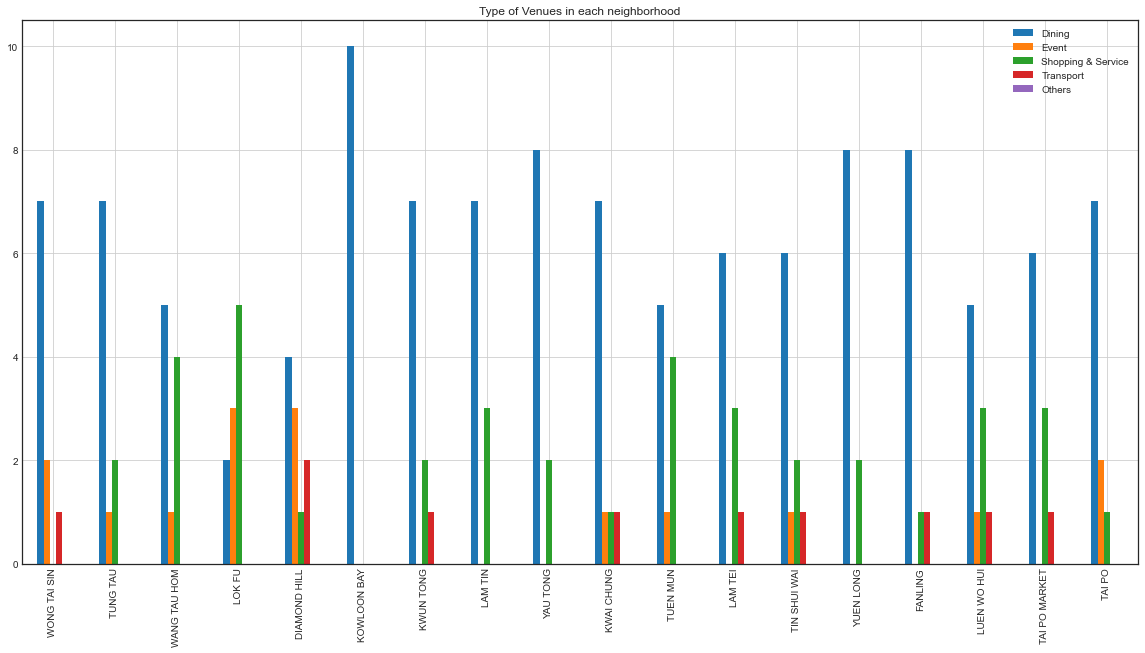

In [200]:
plt.style.use('seaborn-white')
hk_cluster_TEST.plot.bar(figsize=(20,10),grid=True, title='Type of Venues in each neighborhood')
plt.xticks(list(range(len(hk_cluster_TEST.Neighborhood))), hk_cluster_TEST.Neighborhood, fontsize=10)
plt.show()

#### Conclusion
After filtering out neighborhoods in Hong Kong that already have venues providing siimiliar sport/gym services to the communities, and expensive neighborhoods, the final list of potential neighborhoods have been narrowed down from 122 to 17. 

With these 17 neighborhoods, the top 10 most common venues are grouped into 5 big categories, based on the definition provided by Four Square. Economically diverse neighborhoods would attract multiculutural communities to move in, as they have higher tolerance and understanding between different cultures and are accessible, and thus attract more cash flow to the neighborhoods themselves through the growth of different kinds of business. Therefore, I prefer to open a gym business in a diverse neighborhood. 

Based on the bar plot, there's no venues belong to the group "OTHERS" among the 17 neighborhoods, so we would focus on neighborhoods that consist of 4 kinds of venues, which are "LUEN WO HUI", "TIN SHUI WAI", "KWAI CHUNG", and "DIAMOND HILL".
